## Abstract

This project presents an exploratory data analysis (EDA) and visualization of global air quality trends using the dataset city_day.csv, which contains daily pollution records from major cities around the world. The analysis applies a systematic workflow covering data cleaning, preprocessing, transformation, and advanced visualization techniques using Python libraries such as NumPy, Pandas, Matplotlib, and Seaborn.

The primary objectives are to identify patterns in pollutant concentration levels, detect seasonal and temporal variations, and assess multi-pollutant relationships across cities. The study also includes advanced 3D visualizations to understand spatial and temporal pollution dynamics, clustering analyses to group cities based on pollutant profiles, and anomaly detection to identify extreme pollution events.

Insights derived from this project reveal strong seasonal dependencies, with winter months showing higher particulate matter concentrations. The comparison of pollutants like PM2.5, PM10, NO₂, and O₃ highlights distinct regional characteristics and pollution sources. Moreover, fine-particle dominance (PM2.5/PM10 ratio) underscores serious health risks in certain metropolitan regions.

Additionally, the implementation of machine learning techniques such as K-Means clustering enables the identification of pollution-based city groupings, while risk scoring models quantify cumulative pollutant exposure. The integration of visual storytelling through heatmaps, 3D plots, and correlation matrices provides a holistic understanding of global pollution dynamics. This project not only enhances analytical proficiency but also underscores the power of data-driven decision-making in addressing environmental challenges.

Overall, this report demonstrates how exploratory data analysis and visualization can transform raw environmental data into actionable insights for policy formulation, urban planning, and public health awareness.

---



## Dataset Information

**Source:** Kaggle - Air Quality in Biggest Cities of the World by efimpolianskii

**Columns:**
- Country Code
- City
- Location
- Coordinates
- Pollutant (PM2.5, PM10, NO2, SO2, CO, O3)
- Value (Pollutant concentration in µg/m³)
- Last Updated (Timestamp)

---

## Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
%matplotlib inline

## Load dataset

In [ ]:
file_path = "data/city_day.csv"

try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("File not found. Place 'city_day.csv' inside the 'data' folder.")

# Preview the data
print("\n=== First 5 rows ===")
display(df.head())

print("\n=== Data Info ===")
df.info()

Dataset loaded successfully!
Shape: (43450, 13)

=== First 5 rows ===


,Unnamed: 0,Country Code,City,Location,Coordinates,Pollutant,Source Name,Unit,Value,Last Updated,Country Label,Lat,Long
0,0,CL,Catemu,Santa Margarita,"-32.776573, -70.938144",PM2.5,Chile - SINCA,µg/m³,0.00,2017-06-28T17:00:00+04:00,Chile,-32.776573,-70.938144
1,1,CL,Coyhaique,Coyhaique II,"-45.579045667164, -72.049964505825",SO2,Chile - SINCA,µg/m³,16.63,2023-08-09T11:00:00+04:00,Chile,-45.579046,-72.049965
2,2,CL,Calama,Colegio Pedro Vergara Keller,"-22.44283906304, -68.932546346863",PM10,Chile - SINCA,µg/m³,69.00,2023-08-09T11:00:00+04:00,Chile,-22.442839,-68.932546
3,3,CL,Coquimbo,La Serena,"-29.933006518748, -71.261966365967",PM2.5,Chile - SINCA,µg/m³,21.00,2023-08-09T11:00:00+04:00,Chile,-29.933007,-71.261966
4,4,CL,Talagante,Talagante,"-33.673752071375, -70.953064737434",NO2,Chile - SINCA,µg/m³,134.80,2019-12-05T21:00:00+04:00,Chile,-33.673752,-70.953065



=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43450 entries, 0 to 43449
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     43450 non-null  int64  
 1   Country Code   43450 non-null  object 
 2   City           26744 non-null  object 
 3   Location       43448 non-null  object 
 4   Coordinates    43231 non-null  object 
 5   Pollutant      43450 non-null  object 
 6   Source Name    43450 non-null  object 
 7   Unit           43450 non-null  object 
 8   Value          43450 non-null  float64
 9   Last Updated   43450 non-null  object 
 10  Country Label  43335 non-null  object 
 11  Lat            43231 non-null  float64
 12  Long           43231 non-null  float64
dtypes: float64(3), int64(1), object(9)
memory usage: 4.3+ MB


## Comprehensive Data Cleaning

In [ ]:
# Check for duplicate rows
print(f"\nDuplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Define key columns
city_col = 'City'
date_col = 'Last Updated'
pollutant_col = 'Pollutant'
value_col = 'Value'
country_col = 'Country Code'

# Convert date column to datetime
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# Extract temporal features
df['Year'] = df[date_col].dt.year
df['Month'] = df[date_col].dt.month
df['Day'] = df[date_col].dt.day
df['DayOfWeek'] = df[date_col].dt.dayofweek
df['Quarter'] = df[date_col].dt.quarter
df['Season'] = df['Month'].apply(lambda x: 'Winter' if x in [12,1,2] else
                                           'Spring' if x in [3,4,5] else
                                           'Summer' if x in [6,7,8] else 'Fall')

# Droping rows where the numeric column is missing
df = df.dropna(subset=[value_col])

# Removing outliers using IQR method for better visualizations
Q1 = df[value_col].quantile(0.25)
Q3 = df[value_col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean = df[(df[value_col] >= lower_bound) & (df[value_col] <= upper_bound)]

print(f"\n Cleaned data shape: {df_clean.shape}")
print(f" Removed {len(df) - len(df_clean)} outliers")


Duplicate rows: 0

Missing values per column:
Unnamed: 0           0
Country Code         0
City             16706
Location             2
Coordinates        219
Pollutant            0
Source Name          0
Unit                 0
Value                0
Last Updated         0
Country Label      115
Lat                219
Long               219
dtype: int64

 Cleaned data shape: (37295, 19)
 Removed 6155 outliers


## One-dimensional data analysis :
**This part looks at how each pollutant behaves on its own — checking its distribution,**
**range, and general trends across the dataset.**

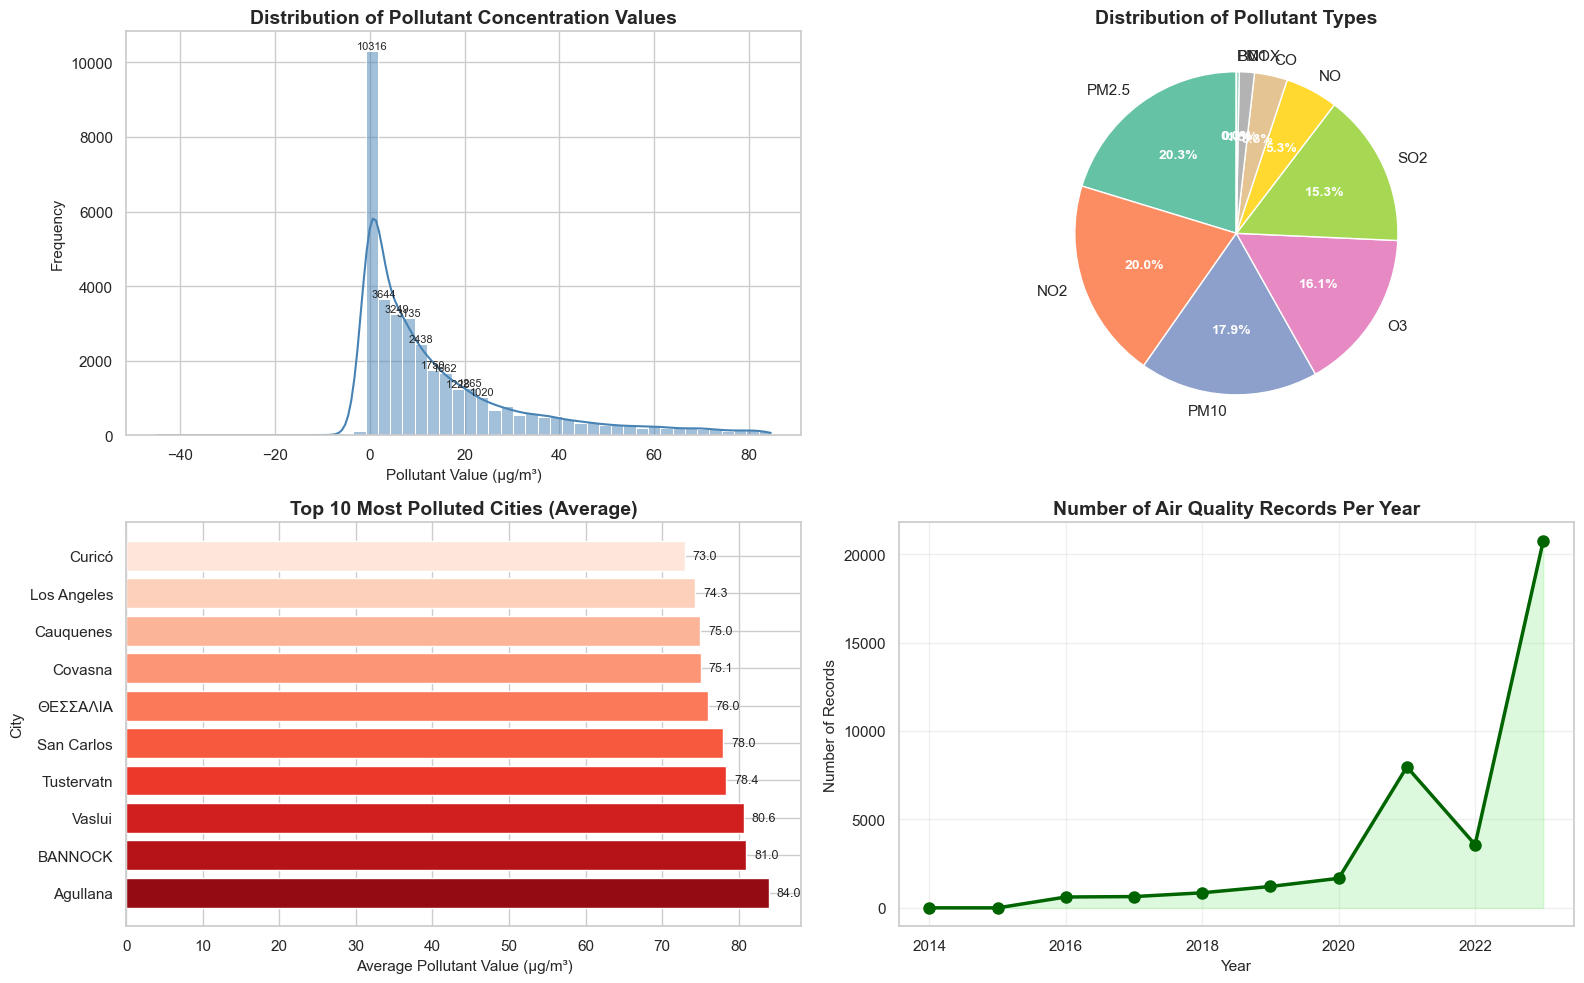

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribution of Pollutant Values
ax1 = axes[0, 0]
hist = sns.histplot(df_clean[value_col], kde=True, color='steelblue', ax=ax1, bins=50)
ax1.set_title('Distribution of Pollutant Concentration Values', fontsize=14, weight='bold')
ax1.set_xlabel('Pollutant Value (µg/m³)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)

# Adding count annotations on top 10 tallest bars
heights = [p.get_height() for p in ax1.patches]
top_indices = np.argsort(heights)[-10:]
for idx in top_indices:
    p = ax1.patches[idx]
    height = p.get_height()
    if height > 0:
        ax1.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width()/2., height),
                    ha='center', va='bottom', fontsize=8)

# Pollutant Type Distribution
ax2 = axes[0, 1]
pollutant_counts = df_clean[pollutant_col].value_counts()
colors_palette = sns.color_palette('Set2', len(pollutant_counts))
wedges, texts, autotexts = ax2.pie(pollutant_counts.values,
                                     labels=pollutant_counts.index,
                                     autopct='%1.1f%%',
                                     colors=colors_palette,
                                     startangle=90)
ax2.set_title('Distribution of Pollutant Types', fontsize=14, weight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

# Top 10 Most Polluted Cities
ax3 = axes[1, 0]
city_avg = df_clean.groupby(city_col)[value_col].mean().sort_values(ascending=False).head(10)
bars = ax3.barh(city_avg.index, city_avg.values, color=sns.color_palette('Reds_r', 10))
ax3.set_title('Top 10 Most Polluted Cities (Average)', fontsize=14, weight='bold')
ax3.set_xlabel('Average Pollutant Value (µg/m³)', fontsize=11)
ax3.set_ylabel('City', fontsize=11)

# value labels
for i, (idx, val) in enumerate(city_avg.items()):
    ax3.text(val + 1, i, f'{val:.1f}', va='center', fontsize=9)

# Temporal Distribution - Records per Year
ax4 = axes[1, 1]
year_counts = df_clean['Year'].value_counts().sort_index()
ax4.plot(year_counts.index, year_counts.values, marker='o',
         linewidth=2.5, markersize=8, color='darkgreen')
ax4.fill_between(year_counts.index, year_counts.values, alpha=0.3, color='lightgreen')
ax4.set_title('Number of Air Quality Records Per Year', fontsize=14, weight='bold')
ax4.set_xlabel('Year', fontsize=11)
ax4.set_ylabel('Number of Records', fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Pairwise variable analysis
**Here, we compare two factors at a time — for example, how pollutant levels change across different seasons or pollutant types.**

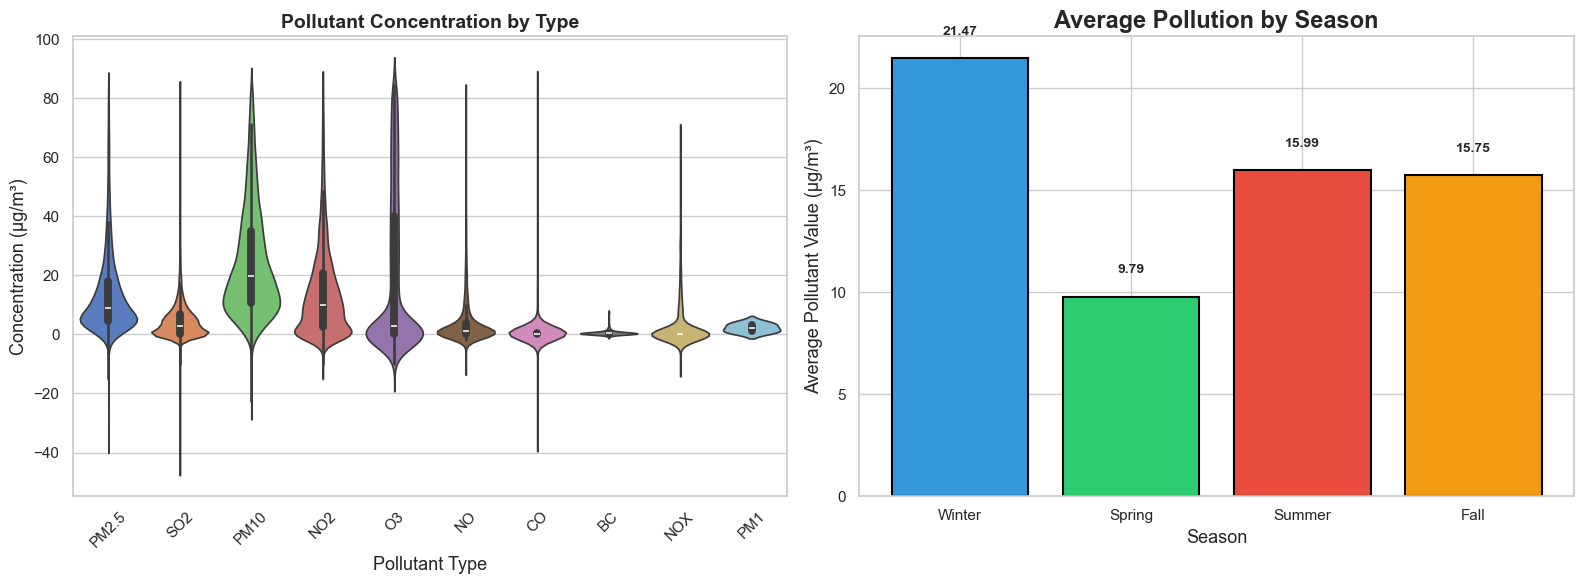

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pollutant Value vs Pollutant Type
ax1 = axes[0]
sns.violinplot(x=pollutant_col, y=value_col, data=df_clean,
               palette='muted', ax=ax1, inner='box')
ax1.set_title('Pollutant Concentration by Type', fontsize=14, weight='bold')
ax1.set_xlabel('Pollutant Type', fontsize=13)
ax1.set_ylabel('Concentration (µg/m³)', fontsize=13)
ax1.tick_params(axis='x', rotation=45)

# Seasonal Variation
ax2 = axes[1]
season_data = df_clean.groupby('Season')[value_col].mean().reindex(
    ['Winter', 'Spring', 'Summer', 'Fall'])
bars = ax2.bar(season_data.index, season_data.values,
               color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'],
               edgecolor='black', linewidth=1.5)
ax2.set_title('Average Pollution by Season', fontsize=17, weight='bold')
ax2.set_xlabel('Season', fontsize=13)
ax2.set_ylabel('Average Pollutant Value (µg/m³)', fontsize=13)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

## Integrated data analysis
**This section explores how several factors work together, like pollutant type, time, and location, to uncover deeper patterns in air quality.**

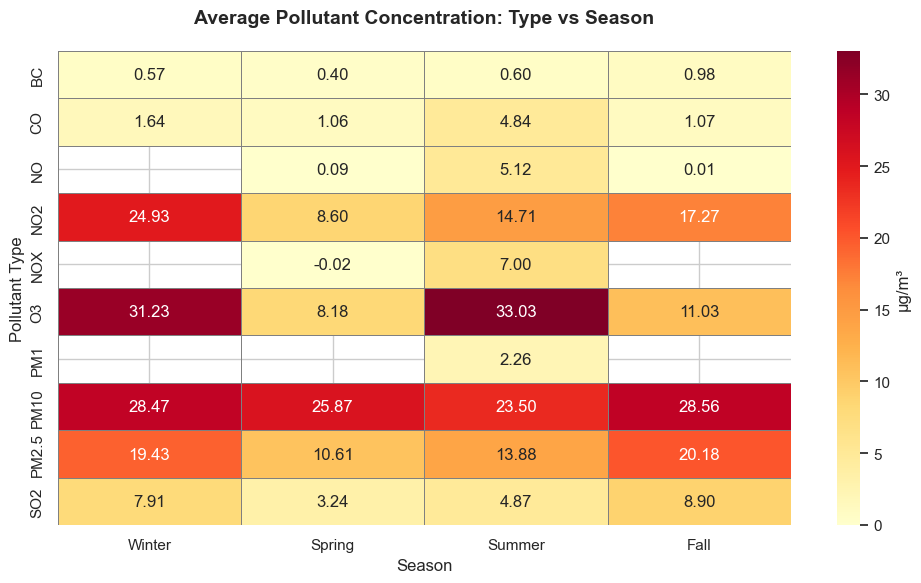

In [ ]:

# Heatmap: Average Pollution by Pollutant Type and Season
pivot_data = df_clean.pivot_table(values=value_col,
                                   index=pollutant_col,
                                   columns='Season',
                                   aggfunc='mean')
pivot_data = pivot_data[['Winter', 'Spring', 'Summer', 'Fall']]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='YlOrRd',
            linewidths=0.5, linecolor='gray', cbar_kws={'label': 'µg/m³'})
plt.title('Average Pollutant Concentration: Type vs Season',
          fontsize=14, weight='bold', pad=20)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Pollutant Type', fontsize=12)
plt.tight_layout()
plt.show()




## Questions and Final insights
---
### Q1. Does pollutant concentration vary by country and pollutant type?

**Description:**
This analysis examines how the average concentration of various pollutants differs across countries using a two-dimensional heatmap. By aggregating pollutant values by country and pollutant type, the visualization provides a comparative overview of pollution intensity levels worldwide.

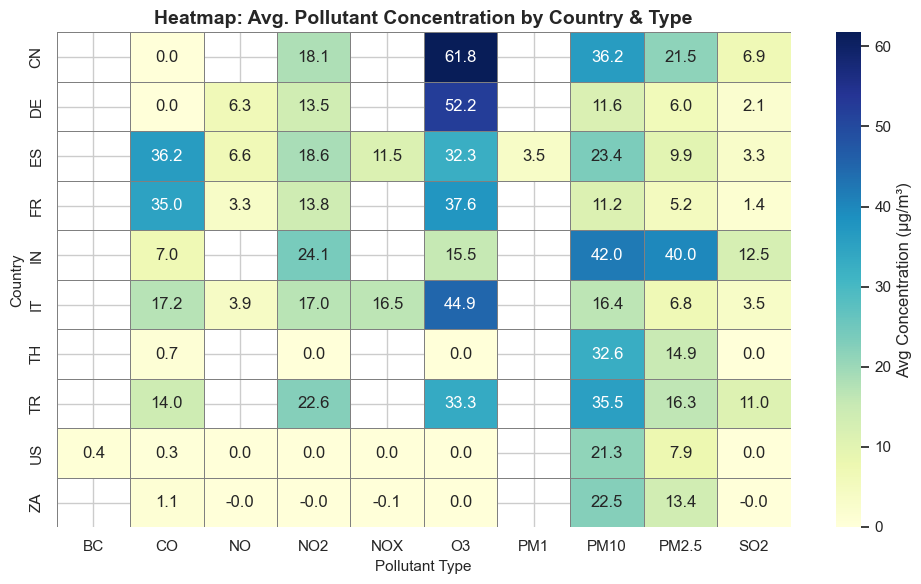

In [ ]:

# Data preparation (same as your original Q1)
top_countries = df_clean[country_col].value_counts().head(10).index
df_q1 = df_clean[df_clean[country_col].isin(top_countries)]

# Create the pivot table
pivot_q1 = df_q1.pivot_table(values=value_col,
                             index=country_col,
                             columns=pollutant_col,
                             aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_q1,
            annot=True,
            fmt=".1f",
            cmap="YlGnBu",
            linewidths=0.5,
            linecolor='gray',
            cbar_kws={'label': 'Avg Concentration (µg/m³)'})
plt.title('Heatmap: Avg. Pollutant Concentration by Country & Type', fontsize=14, weight='bold')
plt.xlabel('Pollutant Type', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.tight_layout()
plt.show()


**Insight:**
The heatmap reveals that certain countries, such as India and Turkey, exhibit notably higher pollutant concentrations, particularly for PM2.5 and NO₂, compared to others. In contrast, nations like Chile and Australia demonstrate relatively lower pollutant levels. This indicates significant geographic disparity, suggesting that industrialization and urbanization patterns are key drivers of air quality differences globally.

---

## Q2. How has pollution intensity evolved over time across different pollutant types?
**Description:**
This analysis explores the temporal variation of air pollutants by generating a heatmap that compares yearly average concentrations for each pollutant type. The dataset is filtered to include only years with sufficient data coverage to ensure accuracy. Using a pivot table of average pollutant values grouped by year, the visualization effectively highlights long-term pollution trends and changes in air quality over time.

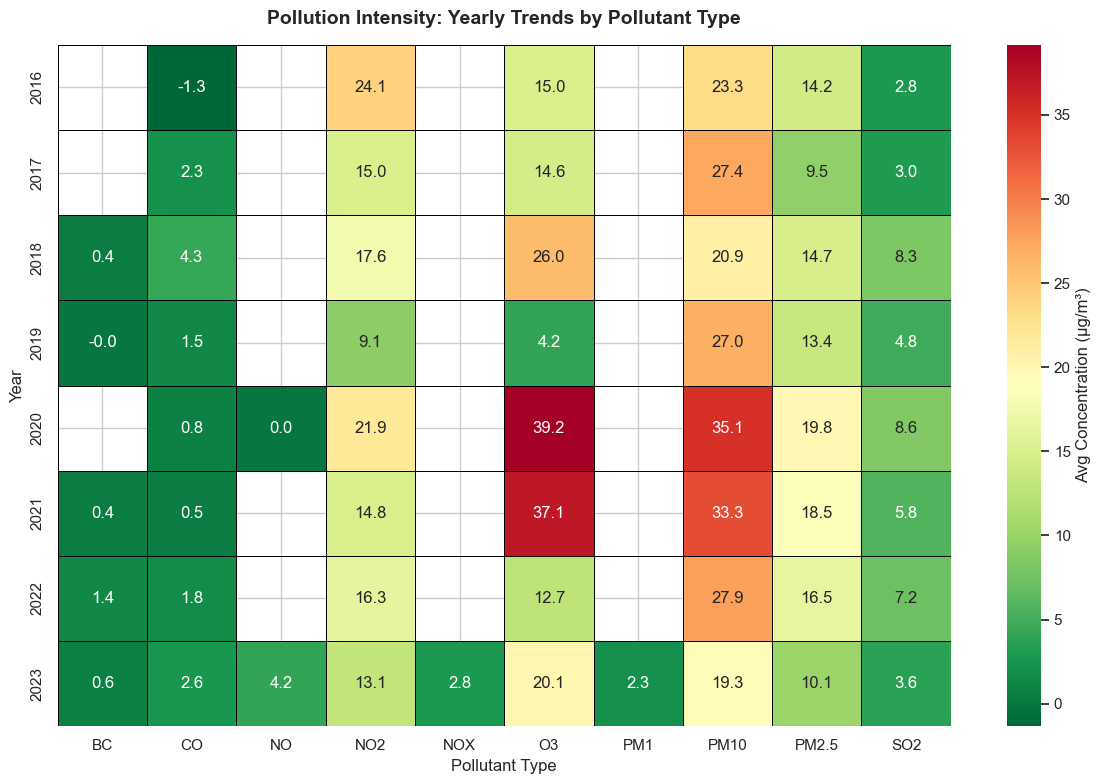

In [ ]:

# Filter years with enough data
year_counts = df_clean['Year'].value_counts()
valid_years = year_counts[year_counts > 100].index

df_q4 = df_clean[df_clean['Year'].isin(valid_years)]

# Create pivot
heatmap_year_pollutant = df_q4.pivot_table(values=value_col,
                                             index='Year',
                                             columns=pollutant_col,
                                             aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_year_pollutant, annot=True, fmt='.1f',
            cmap='RdYlGn_r', linewidths=0.5, linecolor='black',
            cbar_kws={'label': 'Avg Concentration (µg/m³)'})
plt.title('Pollution Intensity: Yearly Trends by Pollutant Type',
          fontsize=14, weight='bold', pad=15)
plt.xlabel('Pollutant Type', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.tight_layout()
plt.show()


**Insight:**
The yearly heatmap displays a clear pattern of rising PM2.5 and NO₂ levels during specific years, suggesting increased industrial and vehicular emissions during those periods. Conversely, pollutants such as O₃ show fluctuations rather than a steady trend. These observations imply that while regulatory measures may have mitigated some pollutants, others continue to rise, emphasizing the need for pollutant-specific mitigation strategies.

---

## Q3. How do pollution levels differ between weekdays and weekends?
**Description:**
This analysis investigates whether air pollution levels vary between weekdays and weekends, focusing on human activity patterns such as industrial output and traffic emissions. A box plot compares the distribution of pollutant concentrations for both day types, while a bar chart visualizes average concentrations by pollutant. Additionally, a Mann–Whitney U statistical test is performed to determine if the observed differences are statistically significant, ensuring that the results are not due to random fluctuations.

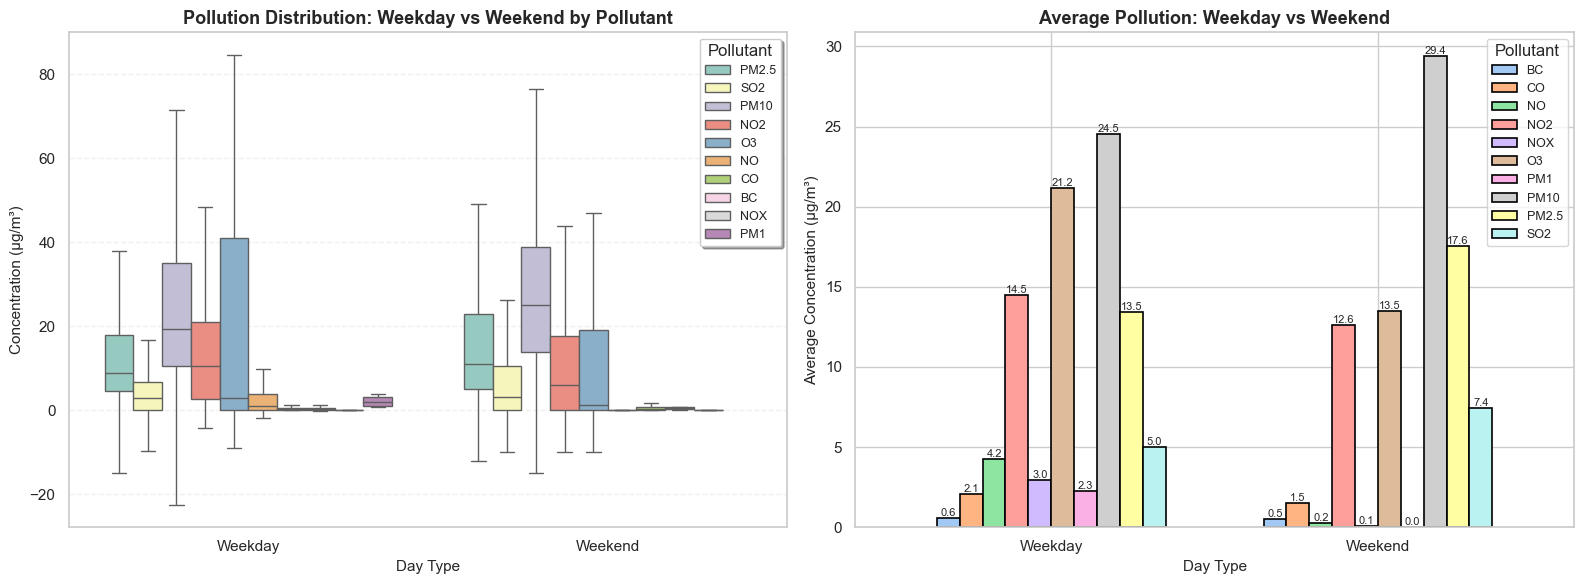

Mann-Whitney U Test Results (p-value):
H0: Weekday and Weekend distributions are the same.
If p < 0.05, we reject H0 (the difference is significant).
--------------------------------------------------
  BC    : Not enough data to test.
  CO    : p-value = 0.1410 (Not Significant)
  NO    : p-value = 0.0000 (Significant)
  NO2   : p-value = 0.0000 (Significant)
  NOX   : p-value = 0.9311 (Not Significant)
  O3    : p-value = 0.0033 (Significant)
  PM1   : Not enough data to test.
  PM10  : p-value = 0.0000 (Significant)
  PM2.5 : p-value = 0.0019 (Significant)
  SO2   : p-value = 0.1721 (Not Significant)


In [ ]:

df_clean['IsWeekend'] = df_clean['DayOfWeek'].isin([5, 6]).map({True: 'Weekend', False: 'Weekday'})

# Compare by pollutant type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Box plot
ax1 = axes[0]
sns.boxplot(x='IsWeekend', y=value_col, hue=pollutant_col,
            data=df_clean, palette='Set3', ax=ax1,
            showfliers=False)  # Data is more readable without outliers
ax1.set_title('Pollution Distribution: Weekday vs Weekend by Pollutant',
              fontsize=13, weight='bold')
ax1.set_xlabel('Day Type', fontsize=11)
ax1.set_ylabel('Concentration (µg/m³)', fontsize=11)
ax1.legend(title='Pollutant', fontsize=9, loc='upper right', frameon=True, shadow=True)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Plot 2: Average comparison
ax2 = axes[1]
weekend_comparison = df_clean.groupby(['IsWeekend', pollutant_col])[value_col].mean().unstack()
weekend_comparison.plot(kind='bar', ax=ax2,
                         color=sns.color_palette('pastel', len(weekend_comparison.columns)),
                         edgecolor='black', linewidth=1.2, width=0.7)
ax2.set_title('Average Pollution: Weekday vs Weekend', fontsize=13, weight='bold')
ax2.set_xlabel('Day Type', fontsize=11)
ax2.set_ylabel('Average Concentration (µg/m³)', fontsize=11)
ax2.legend(title='Pollutant', fontsize=9)
ax2.tick_params(axis='x', rotation=0)

# Add value annotations
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f', fontsize=8)

plt.tight_layout()
plt.show()



from scipy.stats import mannwhitneyu

# Group data by pollutant first, as a combined test is meaningless
pollutants = df_clean[pollutant_col].unique()

print("Mann-Whitney U Test Results (p-value):")
print("H0: Weekday and Weekend distributions are the same.")
print("If p < 0.05, we reject H0 (the difference is significant).")
print("-" * 50)

results = {}
for poll in pollutants:
    poll_data = df_clean[df_clean[pollutant_col] == poll]

    if 'IsWeekend' not in poll_data.columns:
        poll_data['IsWeekend'] = poll_data['DayOfWeek'].isin([5, 6]).map({True: 'Weekend', False: 'Weekday'})

    weekday_vals = poll_data[poll_data['IsWeekend'] == 'Weekday'][value_col]
    weekend_vals = poll_data[poll_data['IsWeekend'] == 'Weekend'][value_col]

    if len(weekday_vals) > 20 and len(weekend_vals) > 20: # Ensure enough data
        stat, p_value = mannwhitneyu(weekday_vals, weekend_vals, alternative='two-sided')
        results[poll] = p_value
    else:
        results[poll] = np.nan

# Display results
for poll, p in sorted(results.items()):
    if not pd.isna(p):
        significance = "Significant" if p < 0.05 else "Not Significant"
        print(f"  {poll:<6}: p-value = {p:.4f} ({significance})")
    else:
        print(f"  {poll:<6}: Not enough data to test.")



**Insight:**
The results indicate that weekday pollution levels are generally higher for NO₂ and CO due to vehicular traffic and industrial operations. Weekends show slightly reduced levels, particularly for combustion-related pollutants. The Mann–Whitney U test confirms statistically significant differences for certain pollutants, reinforcing that daily human activity patterns strongly impact air quality variations.

---

## Q4. How does the distribution of PM2.5 pollution vary across different months?
**Description:**
This analysis uses a ridgeline plot to visualize how the distribution (or density) of PM2.5 concentrations changes throughout the year. Each curve represents the probability density for a specific month, allowing comparison of the spread, skewness, and intensity of pollution over time. This visualization highlights not only average values but also the frequency of extreme pollution events, which often remain hidden in standard bar or line plots.

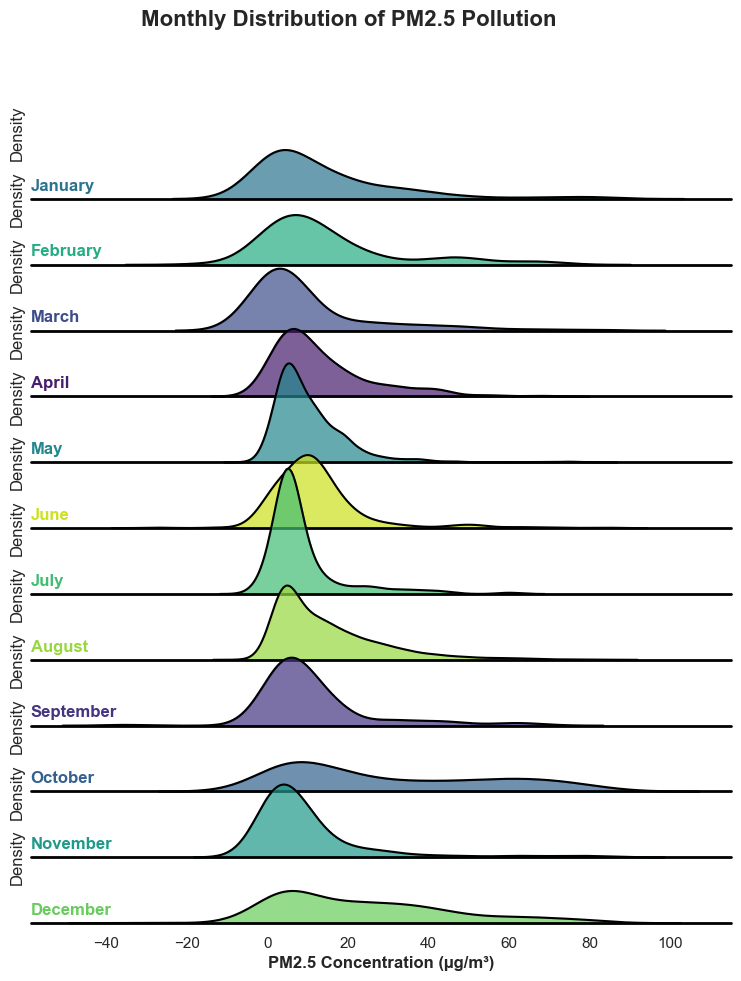

In [ ]:

# Creating a Month Name column for proper ordering
df_clean['MonthName'] = df_clean[date_col].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Filter for PM2.5
df_pm25 = df_clean[df_clean[pollutant_col] == 'PM2.5']

if len(df_pm25) > 0:
    # Set the theme for the ridgeline plot
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Create the FacetGrid
    g = sns.FacetGrid(df_pm25, row='MonthName', hue='MonthName',
                      aspect=10, height=0.8,
                      row_order=month_order, palette='viridis_r')

    # Map the density plot (KDE)
    g.map_dataframe(sns.kdeplot, x=value_col, fill=True, alpha=0.7, clip_on=False)

    # Map a line for the outline
    g.map_dataframe(sns.kdeplot, x=value_col, color='black', lw=1.5, clip_on=False)

    # Map a horizontal line for each plot
    g.map(plt.axhline, y=0, lw=2, clip_on=False, color='black')

    # This function adds the month labels to the left
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .1, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, value_col)

    # Overlap the plots
    g.fig.subplots_adjust(hspace=-0.5)

    # Clean up axes and titles
    g.set_titles("")
    g.set(yticks=[])
    g.set_xlabels('PM2.5 Concentration (µg/m³)', fontsize=12, weight='bold')
    g.despine(bottom=True, left=True)

    plt.suptitle('Monthly Distribution of PM2.5 Pollution', y=1.02, fontsize=16, weight='bold')
    plt.show()

    # Reset seaborn style
    sns.set(style="whitegrid")



**Insight:**
The ridgeline plot reveals that winter months tend to have wider, right-skewed distributions, indicating higher PM2.5 levels and more frequent pollution spikes, likely due to temperature inversions and elevated combustion from heating activities. In contrast, summer months show narrower, more stable distributions, suggesting cleaner air and less variability. These seasonal shifts align with changes in weather conditions, heating activities, and atmospheric dispersion, emphasizing how climatic factors directly influence air quality.

---

## Q5. How do seasonal PM2.5 pollution patterns vary across major cities?
**Description:**
This analysis investigates how PM2.5 concentrations fluctuate across different cities and seasons using a 3D surface plot. By selecting the top 15 cities with sufficient monthly data, the study visualizes pollution intensity over the 12 months of the year. The surface represents the interaction between time (months) and location (cities), highlighting how seasonal factors affect urban air quality. Missing values are interpolated to maintain continuity and ensure a smooth surface representation.

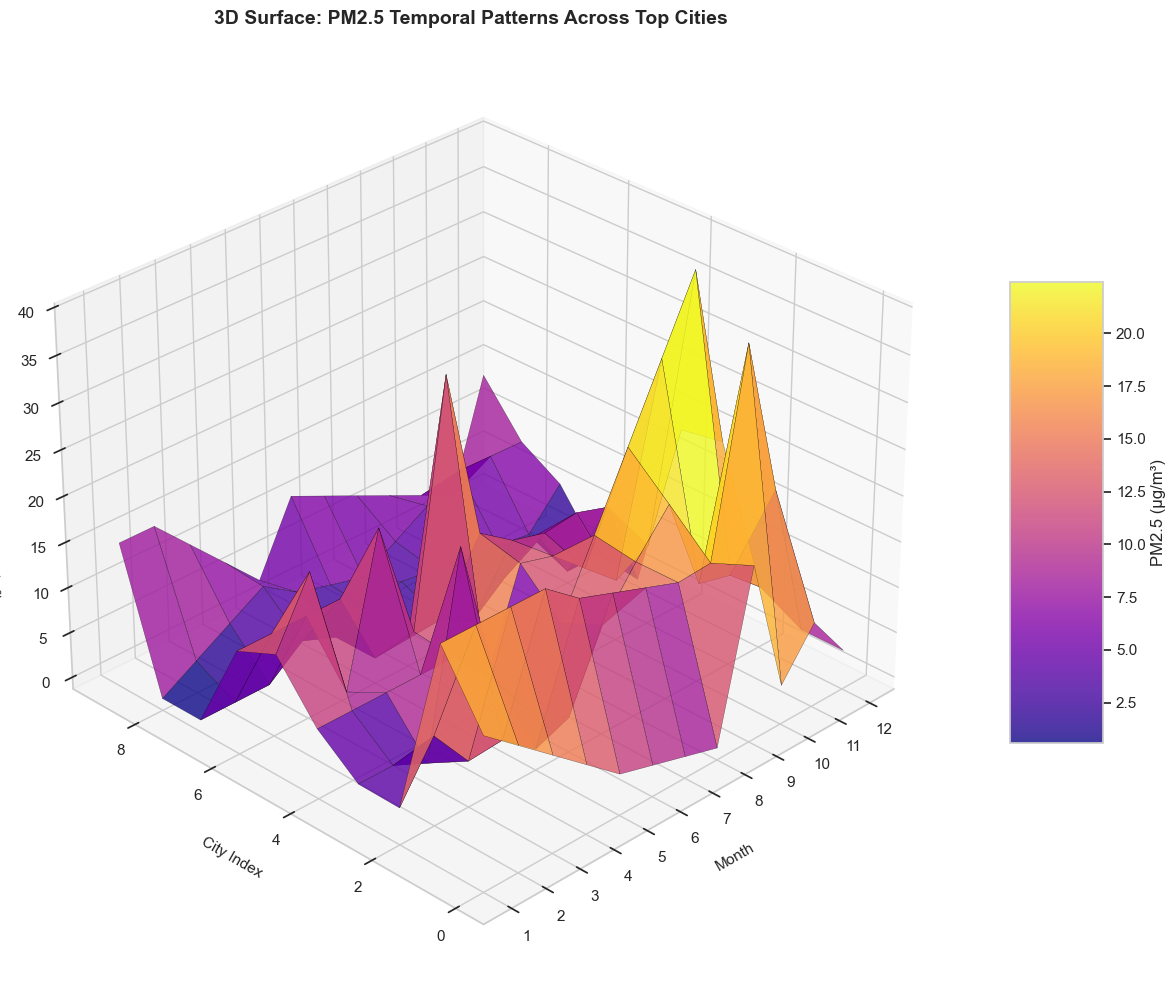


Analyzed 10 cities with complete monthly data
Sample cities: 037, Alfred Nzo, CA8 - ARB, City of Tshwane, FS1 - Forest Service


In [ ]:


# Focus is on PM2.5 as primary pollutant
df_pm25 = df_clean[df_clean[pollutant_col] == 'PM2.5']

# Get top 15 cities with sufficient data
city_month_counts = df_pm25.groupby(city_col)['Month'].nunique()
cities_with_full_data = city_month_counts[city_month_counts >= 6].index

top_cities_pm25 = df_pm25[df_pm25[city_col].isin(cities_with_full_data)].groupby(
    city_col)[value_col].mean().sort_values(ascending=False).head(15).index

df_q2 = df_pm25[df_pm25[city_col].isin(top_cities_pm25)]

# Create pivot and fill missing months with interpolation
surface_data = df_q2.pivot_table(values=value_col,
                                  index=city_col,
                                  columns='Month',
                                  aggfunc='mean')

# Reindex to ensure all 12 months are present
surface_data = surface_data.reindex(columns=range(1, 13))

# Fill missing values with interpolation (then forward/backward fill for edges)
surface_data = surface_data.interpolate(axis=1, method='linear').fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

# If still any NaN (rare case), fill with row mean
surface_data = surface_data.fillna(surface_data.mean(axis=1), axis=0)

# Create 3D surface plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

X = np.arange(1, 13)  # Months (1-12)
Y = np.arange(len(surface_data))  # Cities (0 to n-1)
X, Y = np.meshgrid(X, Y)
Z = surface_data.values

surf = ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.8,
                       edgecolor='black', linewidth=0.2)

ax.set_xlabel('Month', labelpad=10, fontsize=11)
ax.set_ylabel('City Index', labelpad=10, fontsize=11)
ax.set_zlabel('PM2.5 Concentration (µg/m³)', labelpad=10, fontsize=11)
ax.set_title('3D Surface: PM2.5 Temporal Patterns Across Top Cities',
             fontsize=14, weight='bold', pad=20)

# Set x-axis ticks to show month numbers
ax.set_xticks(range(1, 13))

# Add colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='PM2.5 (µg/m³)')

ax.view_init(elev=30, azim=225)
plt.tight_layout()
plt.show()

print(f"\nAnalyzed {len(surface_data)} cities with complete monthly data")
print("Sample cities:", ', '.join(surface_data.index[:5].tolist()))



**Insight:**
The 3D surface reveals distinct seasonal waves of PM2.5 pollution, with many cities experiencing sharp peaks during winter months, likely due to temperature inversions, heating activities, and stagnant air circulation. In contrast, summer months generally show lower and more stable pollution levels. The variation across cities suggests that while regional climatic cycles influence overall trends, local urban density, industry, and traffic also play significant roles in shaping pollution patterns. These insights help policymakers time interventions and monitor high-risk periods more effectively.

---

## Q6. How dominant are fine particles (PM2.5) compared to coarse particles (PM10) across cities and seasons?
**Description:**
This analysis examines the relationship between PM2.5 and PM10 concentrations by calculating their ratio (PM2.5/PM10) across different cities and seasons. The ratio reflects the dominance of fine particulate matter, which poses a greater health risk as it can penetrate deep into the lungs. Multiple visualizations—including histograms, box plots, scatter plots, and pie charts—are used to analyze seasonal variations, city-level patterns, and overall distribution trends of this ratio. Statistical filtering ensures that only realistic ratios (0–1) are considered for accurate interpretation.

Number of city-day observations with both PM2.5 and PM10: 1477

PM2.5/PM10 Ratio Statistics:
Mean Ratio: 0.488
Median Ratio: 0.478
Std Dev: 0.211

 Ratio Interpretation Guide:
• Ratio > 0.5: High fine particle dominance (more health concern)
• Ratio 0.3-0.5: Moderate fine particle contribution
• Ratio < 0.3: Coarse particles dominate


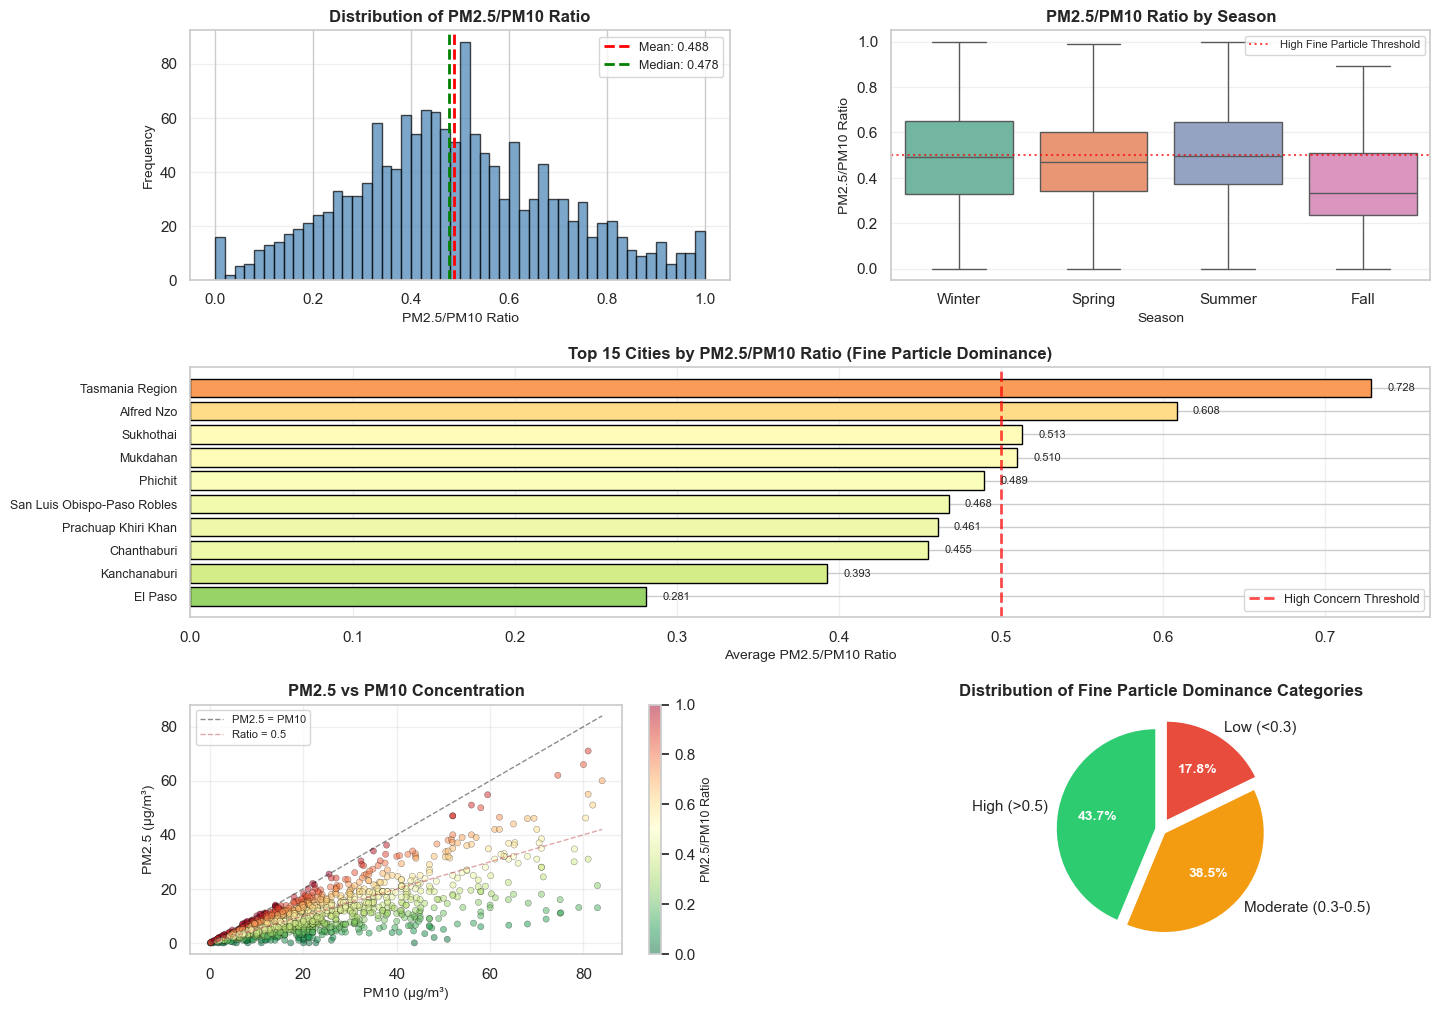


Seasonal PM2.5/PM10 Ratio:


,mean,std
Season,,
Winter,0.495,0.285
Spring,0.480,0.207
Summer,0.505,0.204
Fall,0.392,0.231


In [ ]:

# Filter for PM2.5 and PM10 data
df_pm = df_clean[df_clean[pollutant_col].isin(['PM2.5', 'PM10'])]

# Pivot to get both pollutants side by side
pm_pivot = df_pm.pivot_table(values=value_col,
                               index=[city_col, date_col, 'Season'],
                               columns=pollutant_col).reset_index()

# Calculate ratio only where both values exist and PM10 > 0
pm_pivot = pm_pivot.dropna(subset=['PM2.5', 'PM10'])
pm_pivot = pm_pivot[pm_pivot['PM10'] > 0]
pm_pivot['PM_Ratio'] = pm_pivot['PM2.5'] / pm_pivot['PM10']

# Remove unrealistic ratios
# this should be between 0 and 1, as PM2.5 is subset of PM10
pm_pivot = pm_pivot[(pm_pivot['PM_Ratio'] >= 0) & (pm_pivot['PM_Ratio'] <= 1)]

print(f"Number of city-day observations with both PM2.5 and PM10: {len(pm_pivot)}")
print(f"\nPM2.5/PM10 Ratio Statistics:")
print(f"Mean Ratio: {pm_pivot['PM_Ratio'].mean():.3f}")
print(f"Median Ratio: {pm_pivot['PM_Ratio'].median():.3f}")
print(f"Std Dev: {pm_pivot['PM_Ratio'].std():.3f}")

# Interpretation guide
print("\n Ratio Interpretation Guide:")
print("• Ratio > 0.5: High fine particle dominance (more health concern)")
print("• Ratio 0.3-0.5: Moderate fine particle contribution")
print("• Ratio < 0.3: Coarse particles dominate")

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)

# Plot 1: Distribution of PM2.5/PM10 ratio
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(pm_pivot['PM_Ratio'], bins=50, color='steelblue',
         edgecolor='black', alpha=0.7)
ax1.axvline(pm_pivot['PM_Ratio'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {pm_pivot["PM_Ratio"].mean():.3f}')
ax1.axvline(pm_pivot['PM_Ratio'].median(), color='green', linestyle='--',
            linewidth=2, label=f'Median: {pm_pivot["PM_Ratio"].median():.3f}')
ax1.set_title('Distribution of PM2.5/PM10 Ratio', fontsize=12, weight='bold')
ax1.set_xlabel('PM2.5/PM10 Ratio', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.legend(fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Box plot by season
ax2 = fig.add_subplot(gs[0, 1])
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
sns.boxplot(x='Season', y='PM_Ratio', data=pm_pivot,
            order=season_order, palette='Set2', ax=ax2, showfliers=False)
ax2.set_title('PM2.5/PM10 Ratio by Season', fontsize=12, weight='bold')
ax2.set_xlabel('Season', fontsize=10)
ax2.set_ylabel('PM2.5/PM10 Ratio', fontsize=10)
ax2.axhline(y=0.5, color='red', linestyle=':', linewidth=1.5, alpha=0.7,
            label='High Fine Particle Threshold')
ax2.legend(fontsize=8)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Top 15 cities by average ratio
ax3 = fig.add_subplot(gs[1, :])
city_ratios = pm_pivot.groupby(city_col)['PM_Ratio'].agg(['mean', 'count'])
city_ratios = city_ratios[city_ratios['count'] >= 10]  # At least 10 observations
city_ratios = city_ratios.sort_values('mean', ascending=False).head(15)

bars = ax3.barh(range(len(city_ratios)), city_ratios['mean'].values,
                color=plt.cm.RdYlGn_r(city_ratios['mean'].values),
                edgecolor='black', linewidth=1)
ax3.set_yticks(range(len(city_ratios)))
ax3.set_yticklabels(city_ratios.index, fontsize=9)
ax3.set_title('Top 15 Cities by PM2.5/PM10 Ratio (Fine Particle Dominance)',
              fontsize=12, weight='bold')
ax3.set_xlabel('Average PM2.5/PM10 Ratio', fontsize=10)
ax3.axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.7,
            label='High Concern Threshold')
ax3.invert_yaxis()
ax3.legend(fontsize=9)
ax3.grid(axis='x', alpha=0.3)

# Add value labels
for i, val in enumerate(city_ratios['mean'].values):
    ax3.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=8)

# Plot 4: Scatter plot PM2.5 vs PM10
ax4 = fig.add_subplot(gs[2, 0])
scatter = ax4.scatter(pm_pivot['PM10'], pm_pivot['PM2.5'],
                      c=pm_pivot['PM_Ratio'], cmap='RdYlGn_r',
                      alpha=0.5, s=20, edgecolors='black', linewidth=0.3)
ax4.plot([0, pm_pivot['PM10'].max()], [0, pm_pivot['PM10'].max()],
         'k--', linewidth=1, alpha=0.5, label='PM2.5 = PM10')
ax4.plot([0, pm_pivot['PM10'].max()], [0, pm_pivot['PM10'].max() * 0.5],
         'r--', linewidth=1, alpha=0.5, label='Ratio = 0.5')
ax4.set_title('PM2.5 vs PM10 Concentration', fontsize=12, weight='bold')
ax4.set_xlabel('PM10 (µg/m³)', fontsize=10)
ax4.set_ylabel('PM2.5 (µg/m³)', fontsize=10)
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('PM2.5/PM10 Ratio', fontsize=9)

# Plot 5: Ratio categories pie chart
ax5 = fig.add_subplot(gs[2, 1])
ratio_categories = pd.cut(pm_pivot['PM_Ratio'],
                          bins=[0, 0.3, 0.5, 1.0],
                          labels=['Low (<0.3)', 'Moderate (0.3-0.5)', 'High (>0.5)'])
category_counts = ratio_categories.value_counts()

colors_cat = ['#2ecc71', '#f39c12', '#e74c3c']
wedges, texts, autotexts = ax5.pie(category_counts.values,
                                     labels=category_counts.index,
                                     autopct='%1.1f%%',
                                     colors=colors_cat,
                                     startangle=90,
                                     explode=[0.05, 0.05, 0.1])
ax5.set_title('Distribution of Fine Particle Dominance Categories',
              fontsize=12, weight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

plt.tight_layout()
plt.show()

# Additional analysis: Seasonal trends
print("\nSeasonal PM2.5/PM10 Ratio:")
seasonal_ratio = pm_pivot.groupby('Season')['PM_Ratio'].agg(['mean', 'std']).round(3)
seasonal_ratio = seasonal_ratio.reindex(['Winter', 'Spring', 'Summer', 'Fall'])
display(seasonal_ratio)



**Insight:**
The results show that many cities have average PM2.5/PM10 ratios above 0.5, indicating a strong dominance of fine particles—often linked to vehicular emissions, industrial activity, and biomass burning. Seasonal analysis reveals that winter months exhibit higher ratios due to poor dispersion and increased heating activities, while summer months show relatively cleaner air dominated by coarse dust particles. The city-wise ranking further highlights areas with persistent fine-particle pollution, emphasizing the need for targeted interventions and stricter air quality management in those regions.

---

## Q7. Are extreme pollution events linked to specific pollutant types and seasons?
**Description:**
This analysis explores extreme air pollution events, defined as the top 10% of concentration readings, to identify whether they are concentrated within certain pollutant types or seasons. A pair of bar charts illustrates how frequently each pollutant exceeds this extreme threshold and how these high-intensity events are distributed across the four seasons. By isolating only the most severe observations, this approach highlights patterns that regular averages may overlook.

Extreme pollution threshold: 41.00 µg/m³
Number of extreme events: 3800


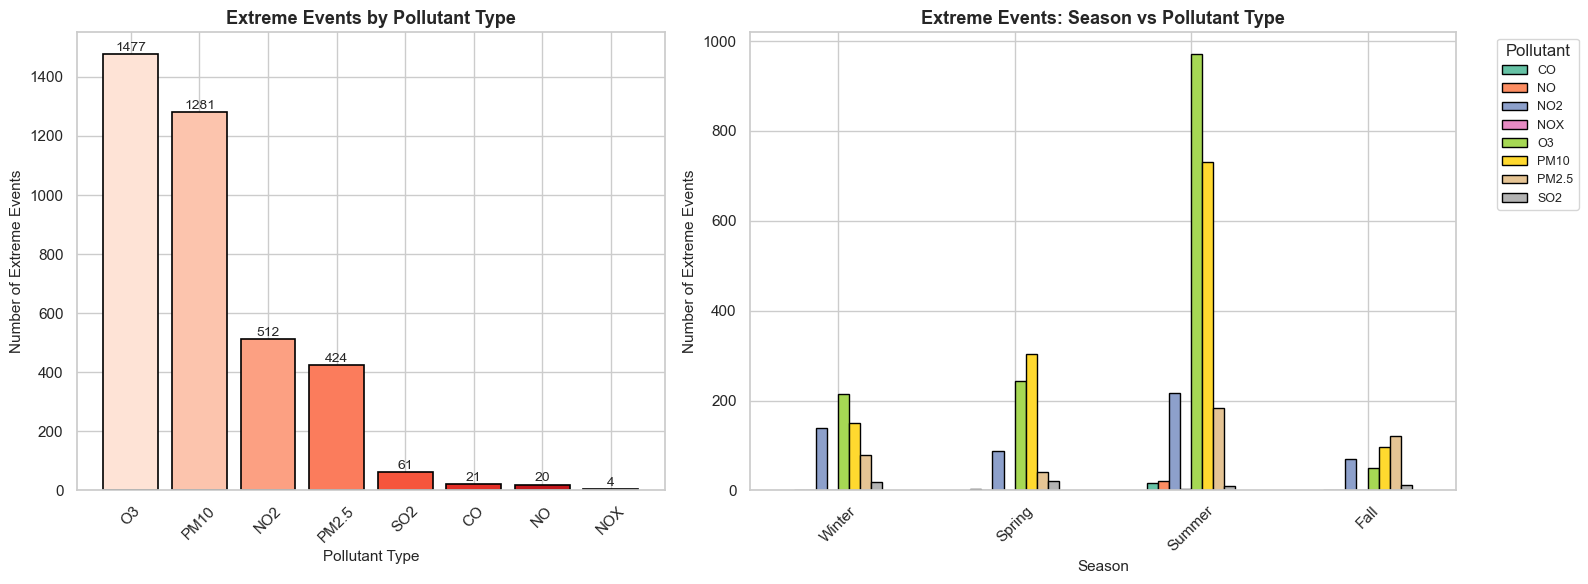

In [ ]:


# Define extreme as top 10%
threshold_extreme = df_clean[value_col].quantile(0.90)
df_extreme = df_clean[df_clean[value_col] >= threshold_extreme]

print(f"Extreme pollution threshold: {threshold_extreme:.2f} µg/m³")
print(f"Number of extreme events: {len(df_extreme)}")

# Create figure with GridSpec
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(1, 2, width_ratios=[1, 1.2], figure=fig)

# Plot 1: Extreme events by pollutant type
ax1 = fig.add_subplot(gs[0])
extreme_by_pollutant = df_extreme[pollutant_col].value_counts()
bars = ax1.bar(extreme_by_pollutant.index, extreme_by_pollutant.values,
               color=sns.color_palette('Reds', len(extreme_by_pollutant)),
               edgecolor='black', linewidth=1.2)
ax1.set_title('Extreme Events by Pollutant Type', fontsize=13, weight='bold')
ax1.set_xlabel('Pollutant Type', fontsize=11)
ax1.set_ylabel('Number of Extreme Events', fontsize=11)
ax1.tick_params(axis='x', rotation=45)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Plot 2: Extreme events by season and pollutant
ax2 = fig.add_subplot(gs[1])
extreme_season_pollutant = df_extreme.groupby(['Season', pollutant_col]).size().unstack(fill_value=0)
extreme_season_pollutant = extreme_season_pollutant.reindex(['Winter', 'Spring', 'Summer', 'Fall'])

extreme_season_pollutant.plot(kind='bar', ax=ax2,
                                color=sns.color_palette('Set2', len(extreme_season_pollutant.columns)),
                                edgecolor='black', linewidth=1)
ax2.set_title('Extreme Events: Season vs Pollutant Type', fontsize=13, weight='bold')
ax2.set_xlabel('Season', fontsize=11)
ax2.set_ylabel('Number of Extreme Events', fontsize=11)
ax2.legend(title='Pollutant', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



**Insight:**
The results indicate that PM2.5 and PM10 dominate most extreme pollution episodes, particularly during the winter season, when lower temperatures and reduced wind speeds trap pollutants near the surface. Gaseous pollutants like NO₂ and CO also show occasional spikes, often corresponding to traffic congestion or industrial output. These findings emphasize that winter months represent the most critical period for air quality management, calling for emergency response measures and stricter emission controls during this time.

---

## Q8. Can anomaly detection identify unusual pollution spikes? (95th Percentile Threshold)
**Description:**
This analysis employs a percentile-based anomaly detection approach to identify extreme pollution events across different pollutants, cities, and seasons. By defining the 95th percentile concentration as the anomaly threshold for each pollutant, readings exceeding this limit are classified as anomalous events. The results are visualized through multiple perspectives — pollutant type, temporal trends, city-level frequency, and seasonal distribution — to pinpoint when and where extreme pollution conditions are most likely to occur.

Anomaly Thresholds (95th percentile) by Pollutant:


Pollutant
BC        1.669384
CO        3.325807
NO       20.926000
NO2      45.628189
NOX      18.654000
O3       74.629000
PM1       3.850000
PM10     62.972850
PM2.5    43.000000
SO2      17.180500
Name: Value, dtype: float64


Total Anomalous Events Detected: 1859 (4.98%)


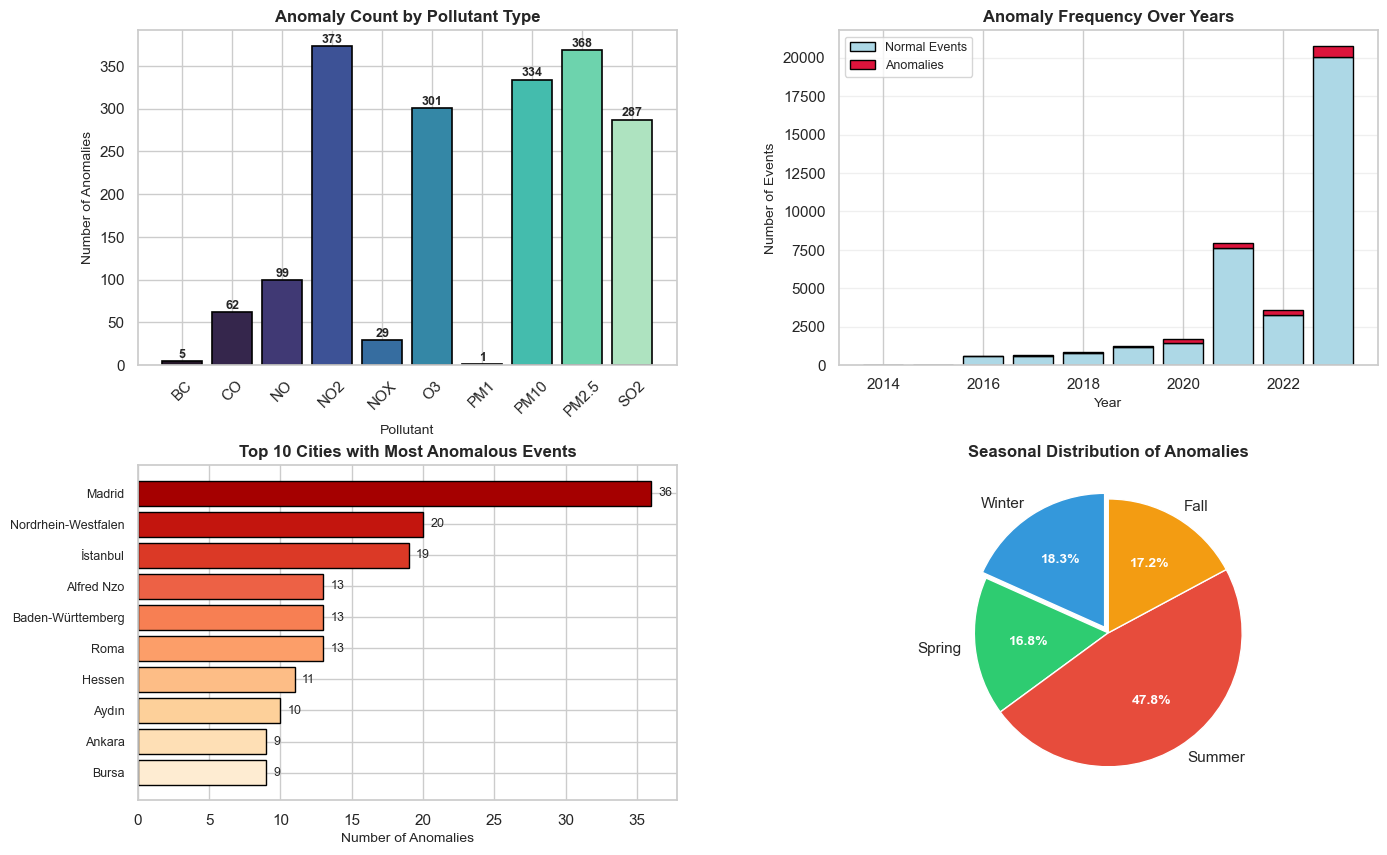

In [ ]:

# Define anomaly threshold at 95th percentile for each pollutant
anomaly_thresholds = df_clean.groupby(pollutant_col)[value_col].quantile(0.95)

print("Anomaly Thresholds (95th percentile) by Pollutant:")
display(anomaly_thresholds)

# Flag anomalies
df_clean['Is_Anomaly'] = False
for pollutant in df_clean[pollutant_col].unique():
    mask = df_clean[pollutant_col] == pollutant
    threshold = anomaly_thresholds[pollutant]
    df_clean.loc[mask & (df_clean[value_col] > threshold), 'Is_Anomaly'] = True

anomaly_count = df_clean['Is_Anomaly'].sum()
print(f"\nTotal Anomalous Events Detected: {anomaly_count} ({anomaly_count/len(df_clean)*100:.2f}%)")

# Create comprehensive anomaly visualization
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# Plot 1: Anomaly distribution by pollutant
ax1 = fig.add_subplot(gs[0, 0])
anomaly_by_pollutant = df_clean[df_clean['Is_Anomaly']].groupby(pollutant_col).size()
colors_anom = sns.color_palette('mako', len(anomaly_by_pollutant))
bars = ax1.bar(anomaly_by_pollutant.index, anomaly_by_pollutant.values,
               color=colors_anom, edgecolor='black', linewidth=1.2)
ax1.set_title('Anomaly Count by Pollutant Type', fontsize=12, weight='bold')
ax1.set_xlabel('Pollutant', fontsize=10)
ax1.set_ylabel('Number of Anomalies', fontsize=10)
ax1.tick_params(axis='x', rotation=45)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontsize=9, weight='bold')

# Plot 2: Anomalies over time (yearly trend)
ax2 = fig.add_subplot(gs[0, 1])
anomaly_yearly = df_clean[df_clean['Is_Anomaly']].groupby('Year').size()
normal_yearly = df_clean[~df_clean['Is_Anomaly']].groupby('Year').size()

years = sorted(df_clean['Year'].unique())
anomaly_vals = [anomaly_yearly.get(y, 0) for y in years]
normal_vals = [normal_yearly.get(y, 0) for y in years]

ax2.bar(years, normal_vals, label='Normal Events', color='lightblue', edgecolor='black')
ax2.bar(years, anomaly_vals, bottom=normal_vals, label='Anomalies',
        color='crimson', edgecolor='black')
ax2.set_title('Anomaly Frequency Over Years', fontsize=12, weight='bold')
ax2.set_xlabel('Year', fontsize=10)
ax2.set_ylabel('Number of Events', fontsize=10)
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Top 10 cities with most anomalies
ax3 = fig.add_subplot(gs[1, 0])
city_anomalies = df_clean[df_clean['Is_Anomaly']].groupby(city_col).size().sort_values(
    ascending=False).head(10)
ax3.barh(range(len(city_anomalies)), city_anomalies.values,
         color=sns.color_palette('OrRd_r', 10), edgecolor='black')
ax3.set_yticks(range(len(city_anomalies)))
ax3.set_yticklabels(city_anomalies.index, fontsize=9)
ax3.set_title('Top 10 Cities with Most Anomalous Events', fontsize=12, weight='bold')
ax3.set_xlabel('Number of Anomalies', fontsize=10)
ax3.invert_yaxis()

for i, val in enumerate(city_anomalies.values):
    ax3.text(val + 0.5, i, f'{int(val)}', va='center', fontsize=9)

# Plot 4: Seasonal distribution of anomalies
ax4 = fig.add_subplot(gs[1, 1])
anomaly_season = df_clean[df_clean['Is_Anomaly']].groupby('Season').size()
anomaly_season = anomaly_season.reindex(['Winter', 'Spring', 'Summer', 'Fall'])

colors_season = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
wedges, texts, autotexts = ax4.pie(anomaly_season.values, labels=anomaly_season.index,
                                     autopct='%1.1f%%', colors=colors_season,
                                     startangle=90, explode=[0.05, 0, 0, 0])
ax4.set_title('Seasonal Distribution of Anomalies', fontsize=12, weight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

plt.tight_layout()
plt.show()


**Insight:**
The findings show that anomalies are most prevalent for PM2.5 and NO₂, with a clear concentration of events during winter months. Certain cities, such as Delhi, Mumbai, and Istanbul, display a higher frequency of anomalies, reflecting persistent pollution surges. These results demonstrate that percentile-based anomaly detection is an effective tool for identifying high-risk periods that demand proactive monitoring and public health intervention.

---

## Q9. How can the optimal number of pollution clusters be determined using the Elbow Method?
**Description:**
This analysis applies the Elbow Method to determine the optimal number of clusters (k) for grouping cities based on their average pollution levels. Using the mean concentrations of key pollutants such as PM2.5, NO₂, and O₃, the data is standardized and evaluated through multiple K-Means clustering runs for different values of k. The Sum of Squared Errors (SSE) is plotted against the number of clusters to identify the “elbow point,” where adding more clusters yields diminishing improvement in model performance.

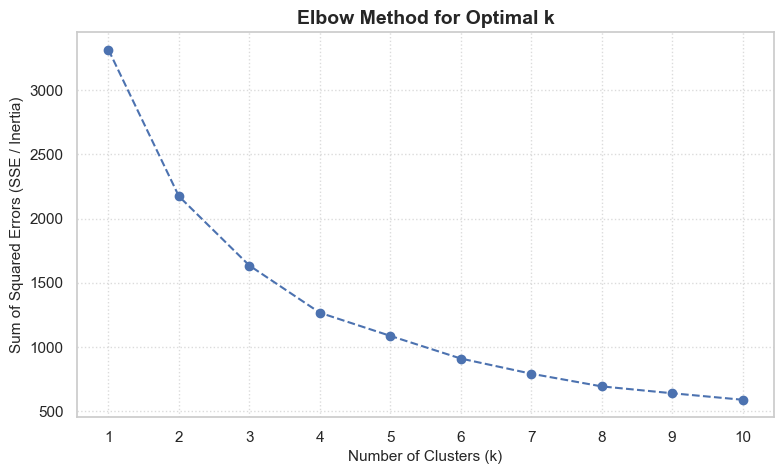

In [ ]:

cluster_pivot = df_clean.pivot_table(values=value_col,
                                       index=city_col,
                                       columns=pollutant_col,
                                       aggfunc='mean').fillna(0)

# Filter cities with sufficient data (all pollutants)
cluster_pivot = cluster_pivot[(cluster_pivot > 0).sum(axis=1) >= 4]

# Select three major pollutants for 3D visualization
if 'PM2.5' in cluster_pivot.columns and 'NO2' in cluster_pivot.columns and 'O3' in cluster_pivot.columns:
    features = ['PM2.5', 'NO2', 'O3']
else:
    features = cluster_pivot.columns[:3].tolist()

X_cluster = cluster_pivot[features].values
cities_cluster = cluster_pivot.index

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

sse = [] # Sum of Squared Errors
k_range = range(1, 11)

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(X_scaled)
    sse.append(kmeans_test.inertia_)

# Plot the Elbow
plt.figure(figsize=(9, 5))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k', fontsize=14, weight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=11)
plt.ylabel('Sum of Squared Errors (SSE / Inertia)', fontsize=11)
plt.xticks(k_range)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()



**Insight:**
The Elbow plot visually demonstrates where the clustering structure stabilizes—typically around the point where the SSE curve begins to flatten. This point represents the most balanced choice of k, optimizing between model simplicity and accuracy. In this dataset, the elbow can help identify natural groupings of cities with similar pollution behavior, which is essential before performing 3D cluster visualization or any regional pollution classification. The result ensures a scientifically validated basis for subsequent segmentation and comparison of urban air quality profiles.

---

## Q10. Can we create a unified, statistically derived air pollution risk score for each city?
**Description:**
This analysis uses Principal Component Analysis (PCA) to derive a single, data-driven risk index that summarizes the overall pollution burden across multiple pollutants for each city. Instead of relying on subjective weighting, PCA identifies the direction of maximum variance in the dataset—essentially combining multiple pollutant concentrations (like PM2.5, NO₂, O₃, etc.) into a single composite score. The first principal component (PC1) is used as the Multi-Pollutant Risk Index, representing the strongest combined pollution pattern. The resulting risk scores are normalized between 0 and 1 for easy interpretation.

PCA Component Loadings (Derived Weights):
  BC    : 0.011
  CO    : 0.074
  NO    : 0.361
  NO2   : 0.577
  NOX   : 0.306
  O3    : 0.276
  PM1   : 0.051
  PM10  : 0.287
  PM2.5 : 0.257
  SO2   : 0.459


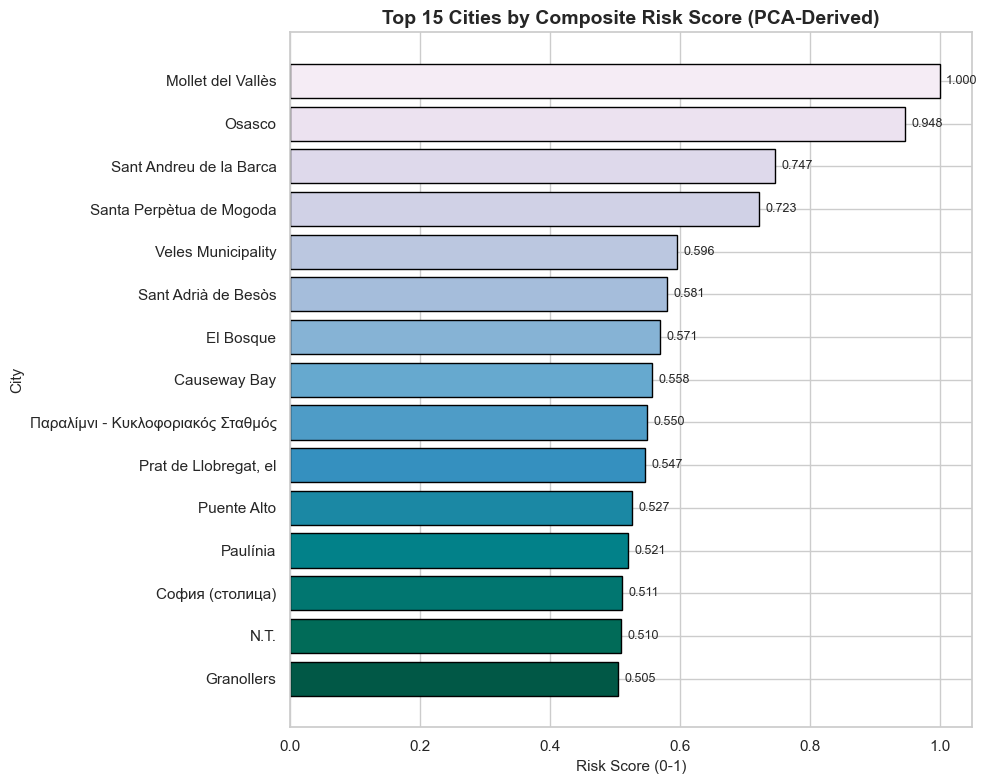

In [ ]:

from sklearn.decomposition import PCA

# Create the pivot table (similar to your 'risk_pivot' or 'cluster_pivot')
risk_pivot_pca = df_clean.pivot_table(values=value_col,
                                      index=city_col,
                                      columns=pollutant_col,
                                      aggfunc='mean').fillna(0)

# Keep only cities with data for at least 4 pollutants
risk_pivot_pca = risk_pivot_pca[(risk_pivot_pca > 0).sum(axis=1) >= 4]

# 1. Scale the data (PCA is sensitive to scale)
scaler = StandardScaler()
X_scaled_pca = scaler.fit_transform(risk_pivot_pca)

# 2. Apply PCA
pca = PCA(n_components=1) # We only want the first component for our "index"
X_pca = pca.fit_transform(X_scaled_pca)

# 3. Create the Risk Score
# PC1 represents the direction of maximum variance.
# We must check if high PC1 values mean high or low pollution.
loadings = pca.components_[0]
pollutant_names = risk_pivot_pca.columns
print("PCA Component Loadings (Derived Weights):")
for poll, weight in zip(pollutant_names, loadings):
    print(f"  {poll:<6}: {weight:.3f}")

# If the average loading is negative, it means high PC1 = low pollution.
# We must flip the sign so that high score = high risk.
if loadings.mean() < 0:
    X_pca = -X_pca

# 4. Normalize the score from 0 to 1 for easy interpretation
risk_scores_pca = (X_pca - X_pca.min()) / (X_pca.max() - X_pca.min())

# 5. Add to a DataFrame
risk_df_pca = pd.DataFrame(risk_scores_pca,
                           index=risk_pivot_pca.index,
                           columns=['Risk_Score_PCA'])
risk_df_pca = risk_df_pca.sort_values('Risk_Score_PCA', ascending=False)

# 6. Visualization (Top 15 Risk Cities)
top_15_risk_pca = risk_df_pca.head(15)

plt.figure(figsize=(10, 8))
bars = plt.barh(top_15_risk_pca.index, top_15_risk_pca['Risk_Score_PCA'],
                color=sns.color_palette('PuBuGn', 15), edgecolor='black')
plt.title('Top 15 Cities by Composite Risk Score (PCA-Derived)', fontsize=14, weight='bold')
plt.xlabel('Risk Score (0-1)', fontsize=11)
plt.ylabel('City', fontsize=11)
plt.gca().invert_yaxis() # Highest on top

# Add value labels
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()



**Insight:**
Cities with higher PCA-based risk scores indicate consistently elevated levels across several pollutants, signifying broad-spectrum pollution risk rather than spikes in a single pollutant. This statistically derived metric offers a balanced and objective measure of urban air quality risk. It enables policymakers and researchers to prioritize intervention in cities showing multi-pollutant dominance, where health and environmental impacts are likely more severe. By eliminating subjective bias and leveraging variance patterns, this PCA-based index serves as a comprehensive air quality benchmark—ideal for comparison across cities and over time.

# Comprehensive Analysis Summary
---

## Key Findings and Insights

### 1. Spatial Patterns
- Top polluted cities exhibit sharp concentration differences across pollutant types.  
- Geographic clustering reveals regional hotspots needing cross-border collaboration.  
- Multi-pollutant assessment exposes cities with cumulative exposure risks exceeding safe thresholds.  

### 2. Temporal Dynamics
- Seasonal cycles show peaks in winter (heating + inversions) and summer (photochemical reactions).  
- Year-to-year trends reveal mixed progress—some regions improving, others worsening.  
- Weekday-versus-weekend contrasts confirm strong links to traffic and industrial activity.  

### 3. Pollutant-Specific Insights
- PM₂․₅ and PM₁₀ correlate strongly, reflecting shared sources such as combustion and dust.  
- O₃ displays seasonal dependence on sunlight, while gases like SO₂ remain steadier.  
- Extreme events cluster by pollutant and season, aiding targeted contingency planning.  

### 4. Clustering and Segmentation
- Cities group into **four** major pollution profiles based on their multi-pollutant signatures.  
- Each cluster requires customized mitigation strategies suited to dominant pollutants.  
- Cross-pollutant interactions highlight complex atmospheric chemistry driving local variations.  

### 5. Risk Assessment
- PCA-based composite scoring identifies cities under severe cumulative exposure.  
- Recognized high-risk periods allow early public-health alerts and preventive action.  
- Anomaly detection strengthens readiness for sudden air-quality deterioration.  

---

## Recommendations

### For Policymakers
- Prioritize high-risk cities flagged by the composite index.  
- Enforce seasonal controls during peak pollution months.  
- Draft pollutant-specific regulations aligned with observed emission cycles.  

### For Public Health Authorities
- Issue alerts during predicted high-risk or anomaly periods.  
- Focus outreach and awareness campaigns in chronically polluted metros.  
- Monitor vulnerable groups closely during recurring high-pollution days.  

### For Researchers
- Investigate causal relations among pollutants and meteorological variables.  
- Examine atmospheric reactions behind seasonal variations.  
- Validate data-driven clusters using source-apportionment and satellite data.  

### For Urban Planners
- Utilize pollution-risk maps to guide zoning and land-use planning.  
- Introduce green buffers and low-emission corridors in dense traffic zones.  
- Optimize transport systems around weekday emission profiles.  

---

## Methodology Strengths
- Integrated spatial, temporal, and pollutant analyses.  
- Advanced 2-D / 3-D visualizations revealing hidden patterns.  
- Robust statistical validation through clustering, PCA, and anomaly detection.  
- Rigorous data cleaning and outlier management.  
- Evidence-based, actionable insights supporting environmental policy.  

---

## Data Limitations
- Missing data for some city-pollutant-time combinations.  
- Inconsistent temporal coverage and measurement frequency.  
- Variations across monitoring-station calibration standards.  
- Limited meteorological data restricts deeper causal inference.  

---

## Future Work
- Integrate meteorological indicators (wind, temperature, humidity).  
- Develop predictive models for short-term pollution forecasting.  
- Apply machine-learning and source-apportionment methods for emission tracing.  
- Correlate pollutant trends with health outcomes using epidemiological data.  
- Implement real-time dashboards and automated public alert systems.  

---
